# ==========================================
# 1. Imports & Configuration
# ==========================================

In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import json

# --- Configuration for Academic Visualizations ---

In [543]:

# Set plot style to 'whitegrid' for better readability
sns.set_style("whitegrid")
# Set context to 'paper' for appropriate font scaling in reports
sns.set_context("paper", font_scale=1.4)

# Ensure pandas displays all columns
pd.set_option('display.max_columns', None)

# --- Path Configuration ---

In [544]:
PROJECT_ROOT = Path("..")
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed"
FIGURES_PATH = PROJECT_ROOT / "results" / "figures"

PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

def save_plot(filename: str) -> None:
    path = FIGURES_PATH / f"{filename}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"[+] Plot saved: {path}")

# ==========================================
# 2. Define Column Names (NSL-KDD specific)
# ==========================================

# The NSL-KDD dataset typically lacks headers. 
# These column names correspond to the official documentation.

In [545]:

COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# ==========================================
# 3. Data Loading
# ==========================================


In [546]:
train_path = os.path.join(RAW_DATA_PATH, 'KDDTrain+.txt')
test_path = os.path.join(RAW_DATA_PATH, 'KDDTest+.txt')

print(f"Loading datasets from: {RAW_DATA_PATH}...")

try:
    train_df = pd.read_csv(train_path, names=COLUMNS)
    test_df = pd.read_csv(test_path, names=COLUMNS)
    print("Data loaded successfully.")
    print(f"Train set dimensions: {train_df.shape}")
    print(f"Test set dimensions:  {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please ensure the data files exist in '{RAW_DATA_PATH}'.")

Loading datasets from: ..\data\raw...
Data loaded successfully.
Train set dimensions: (125973, 43)
Test set dimensions:  (22544, 43)


# ==========================================
# 4. Data Cleaning & Integrity Checks
# ==========================================

# --- 4.1 Missing Values Analysis ---

In [547]:
print("\n[1] Analyzing Missing Values...")
train_nulls = train_df.isnull().sum().sum()
test_nulls = test_df.isnull().sum().sum()
print(f"Total nulls in Train Set: {train_nulls}")
print(f"Total nulls in Test Set:  {test_nulls}")


[1] Analyzing Missing Values...
Total nulls in Train Set: 0
Total nulls in Test Set:  0


# --- 4.2 Duplicate Removal ---

In [548]:
print("\n[2] Analyzing Duplicates...")
dups_train = train_df.duplicated().sum()
print(f"Duplicates found in Train Set: {dups_train}")

if dups_train > 0:
    train_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New Train shape: {train_df.shape}")
else:
    print("No duplicates to remove.")

# Also clean Test set for consistency
dups_test = test_df.duplicated().sum()
if dups_test > 0:
    test_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed from Test Set: {dups_test}")


[2] Analyzing Duplicates...
Duplicates found in Train Set: 0
No duplicates to remove.


# --- 4.3 Feature Selection (Dropping Metadata) ---

# The 'difficulty' column is metadata used for evaluating learners, not for training.

In [549]:
if 'difficulty' in train_df.columns:
    train_df.drop('difficulty', axis=1, inplace=True)
    test_df.drop('difficulty', axis=1, inplace=True)
    print("\n[3] Dropped 'difficulty' metadata column.")


[3] Dropped 'difficulty' metadata column.


# ==========================================
# 5. Exploratory Data Analysis (EDA)
# ==========================================


# Create a binary label for visualization purposes (Normal vs Attack)

In [550]:
train_df['binary_label'] = train_df['label'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack')

# --- 5.1 Class Distribution (Target Variable) ---


[4] Visualizing Class Distribution...
[+] Plot saved: ..\results\figures\class_distribution.png


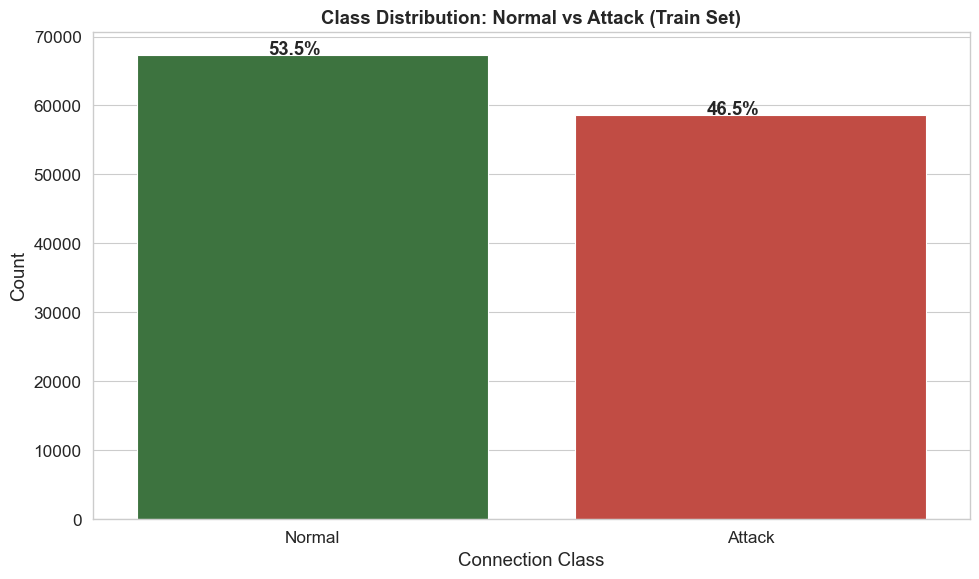

binary_label
Normal    67343
Attack    58630
Name: count, dtype: int64


In [551]:
print("\n[4] Visualizing Class Distribution...")

train_df["binary_label"] = np.where(train_df["label"] == "normal", "Normal", "Attack")

plt.figure(figsize=(10, 6))
palette = {'Normal': "#347C36", 'Attack': "#D63A2F"}

ax = sns.countplot(
    data=train_df,
    x='binary_label',
    hue='binary_label',
    palette=palette,
    legend=False
)

plt.title('Class Distribution: Normal vs Attack (Train Set)', fontweight='bold')
plt.xlabel('Connection Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 150
    ax.annotate(percentage, (x, y), weight='bold')

save_plot('class_distribution')
plt.tight_layout()
plt.show()

print(train_df["binary_label"].value_counts())



# --- 5.2 Protocol Type Distribution ---


[5] Visualizing Protocol Types by Class...
[+] Plot saved: ..\results\figures\protocol_distribution.png


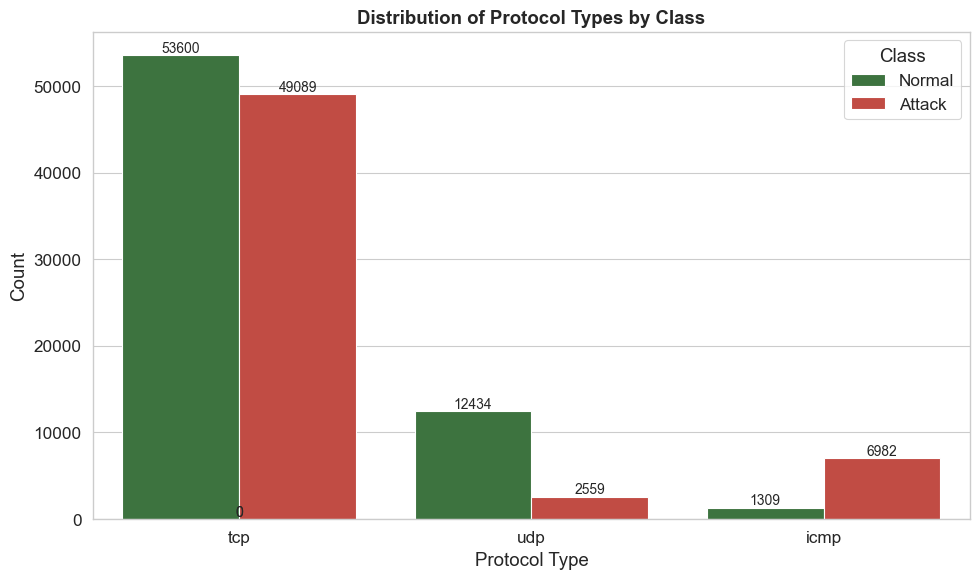

In [552]:
print("\n[5] Visualizing Protocol Types by Class...")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='protocol_type', hue='binary_label', data=train_df, palette=palette)
plt.title('Distribution of Protocol Types by Class', fontweight='bold')
plt.xlabel('Protocol Type')
plt.ylabel('Count')
plt.legend(title='Class')
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center',
        fontsize=10,
        xytext=(0, 5),
        textcoords='offset points')
save_plot('protocol_distribution')
plt.tight_layout()
plt.show()

# --- 5.3 Correlation Analysis (Heatmap) ---


[6] generating Correlation Matrix...
Top positively correlated with Attack:


binary_target               1.000000
dst_host_srv_serror_rate    0.654985
dst_host_serror_rate        0.651842
serror_rate                 0.650652
srv_serror_rate             0.648289
count                       0.576444
dst_host_count              0.375052
srv_rerror_rate             0.253504
dst_host_srv_rerror_rate    0.253430
rerror_rate                 0.253397
Name: binary_target, dtype: float64

Top negatively correlated with Attack:


num_file_creations       -0.021271
su_attempted             -0.022448
num_access_files         -0.036701
is_guest_login           -0.039279
srv_diff_host_rate       -0.119377
logged_in                -0.690171
dst_host_same_srv_rate   -0.693803
dst_host_srv_count       -0.722535
same_srv_rate            -0.751913
num_outbound_cmds              NaN
Name: binary_target, dtype: float64

[+] Plot saved: ..\results\figures\correlation_matrix.png


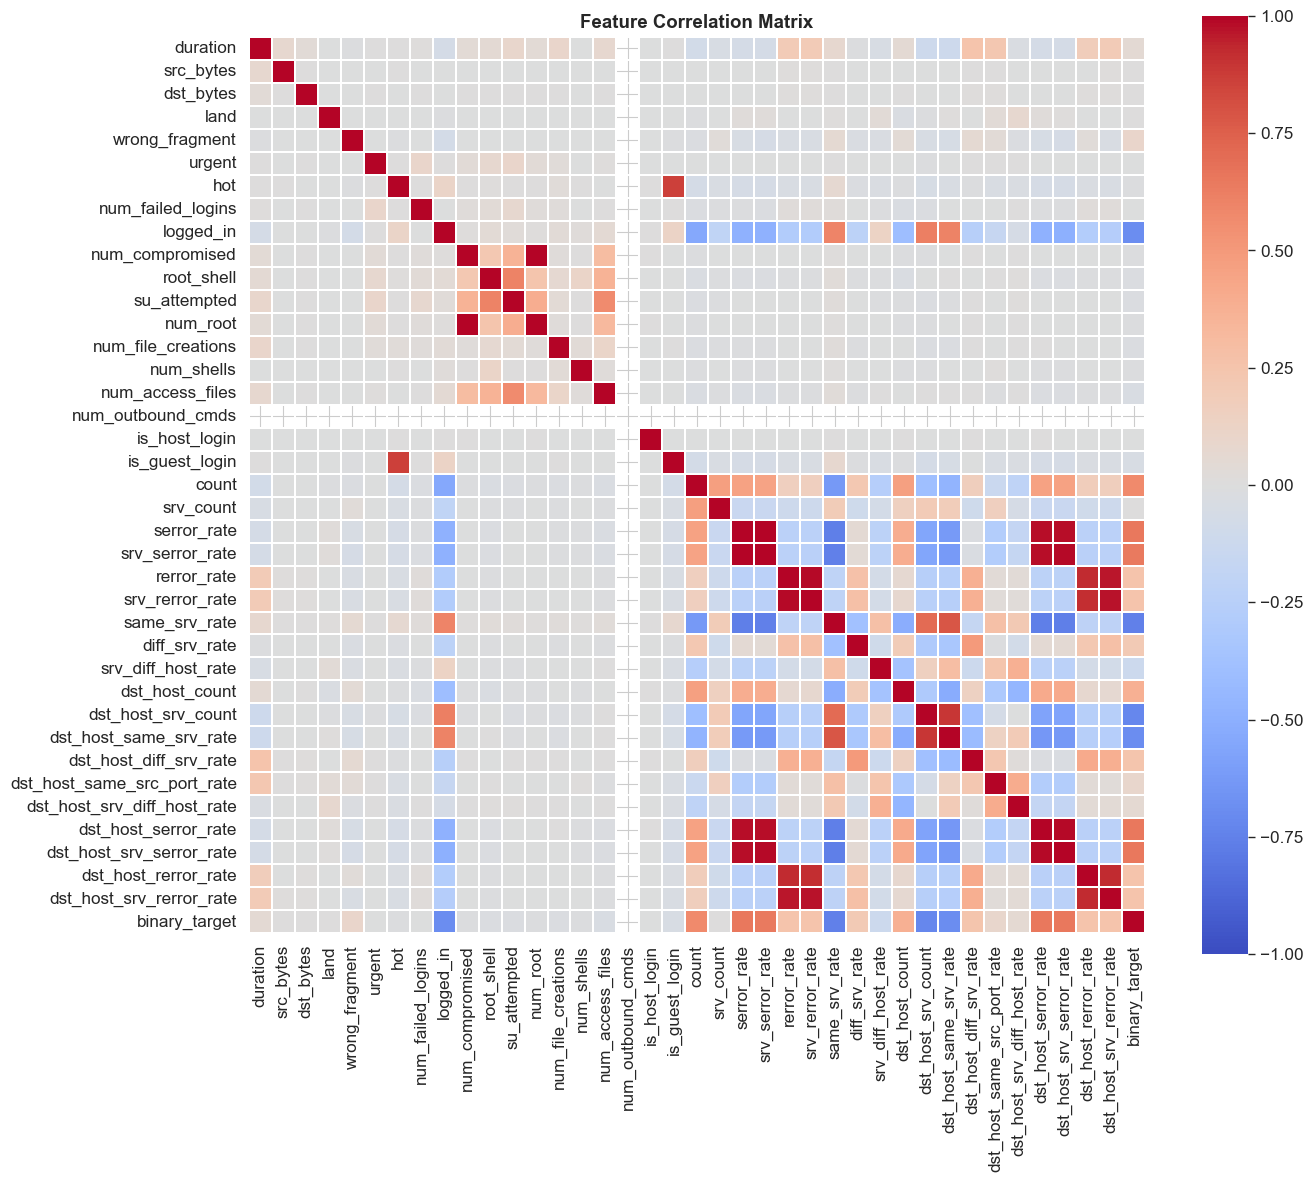

In [553]:
print("\n[6] generating Correlation Matrix...")
plt.figure(figsize=(14, 12))

train_df['binary_target'] = (train_df['label'] != 'normal').astype(int)

# Encode non-numeric features temporarily for correlation
numeric_df = train_df.select_dtypes(include=[np.number])
corr_with_target = numeric_df.corr()['binary_target'].sort_values(ascending=False)

print("Top positively correlated with Attack:")
display(corr_with_target.head(10))

print("Top negatively correlated with Attack:")
display(corr_with_target.tail(10))

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm', 
    vmax=1.0, 
    vmin=-1.0, 
    linewidths=0.1,
    annot=False, # Too cluttered with annotations for 40 features
    square=True
)
plt.title('Feature Correlation Matrix', fontweight='bold')
save_plot('correlation_matrix')
plt.tight_layout()
plt.show()


# --- 5.4 Distribution of Key Features (Boxplots) ---


[7] Visualizing Key Feature Distributions...
[+] Plot saved: ..\results\figures\key_features_boxplots.png


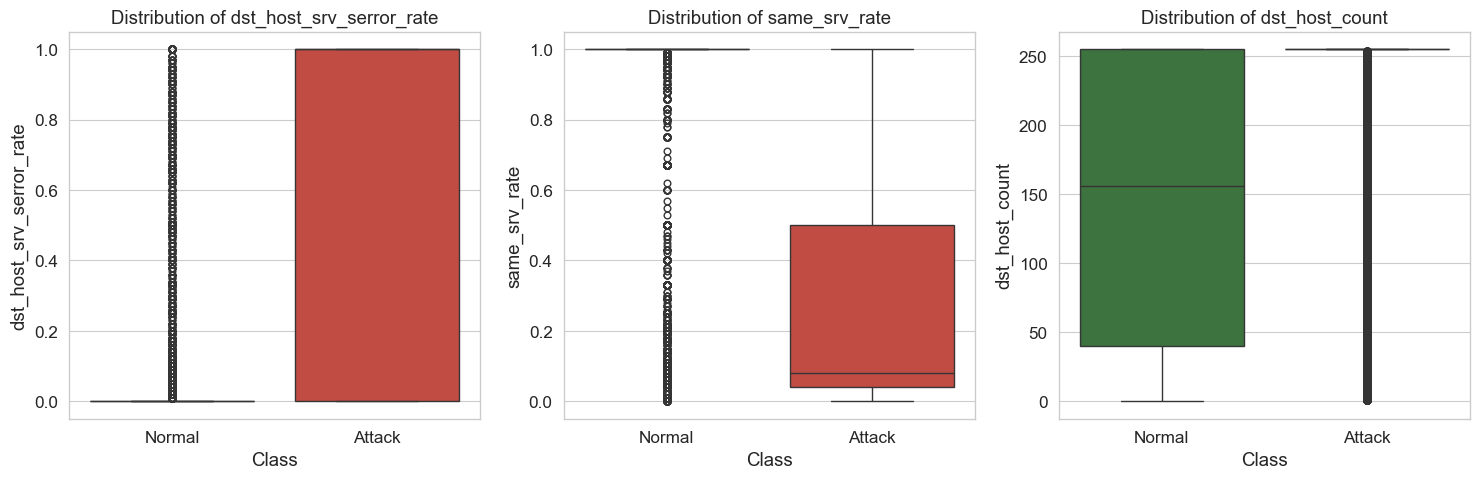

In [554]:
key_features = ['dst_host_srv_serror_rate', 'same_srv_rate', 'dst_host_count']

print("\n[7] Visualizing Key Feature Distributions...")
plt.figure(figsize=(15, 5))
for i, col in enumerate(key_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(
        data=train_df,
        x='binary_label',
        y=col,
        hue='binary_label',
        palette=palette,
        dodge=False,
        legend=False
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel('Class')

plt.tight_layout()
save_plot('key_features_boxplots')
plt.tight_layout()
plt.show()

train_df.drop(columns=["binary_label"], inplace=True)

This figure presents boxplot visualizations of selected network traffic features
for normal and attack traffic. The observed differences in distributions indicate
that these features exhibit strong discriminative power and support their use
in subsequent machine learning models for anomaly detection.

In [555]:
# Save raw schema for realtime feature extraction (before encoding/scaling)
raw_feature_cols = [c for c in train_df.columns if c not in ["label"]]

schema = {
    "raw_feature_columns": raw_feature_cols,
    "categorical_columns": ["protocol_type", "service", "flag"]
}

schema_path = PROCESSED_DATA_PATH / "realtime_schema.json"
with open(schema_path, "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)

print(f"[+] Saved realtime schema: {schema_path}")


[+] Saved realtime schema: ..\data\processed\realtime_schema.json


# ==========================================
# 6. Save Processed Data
# ==========================================

In [556]:
print(f"\n[8] Saving cleaned datasets to '{PROCESSED_DATA_PATH}'...")
train_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'train_cleaned.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'test_cleaned.csv'), index=False)
print("Done. Files saved successfully.")


[8] Saving cleaned datasets to '..\data\processed'...
Done. Files saved successfully.
